# Retrieval results visualizations

In [7]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import json
from dataset import *
from triplet_loss import *
from embedding_model import *
import argparse
from sklearn.metrics import roc_auc_score, roc_curve
import annoy
import pickle
import PIL
from PIL import ImageOps
import hnswlib

In [2]:
# load product meta data
mode ='test'
with open('/home/hongruz_google_com/Documents/vasileva2018_learning/fashion-compatibility-master/data/polyvore_outfits/disjoint/%s.json' % mode) as f:
    outfit_ls = json.load(f)

idx2item_id = {}
for outfit in outfit_ls:
#     print (outfit)
    outfit_id = int(outfit['set_id'])
    idx2item_id[outfit_id] = {}
    for each in outfit['items']:
        idx2item_id[outfit_id][each['index']] = int(each['item_id'])
cate_dict,item_list = read_files()
embedding_color_dict,embedding_pattern_dict = load_embeddings(item_list)
cate_id = {'': 0,
         'tops': 1,
         'bottoms': 2,
         'hats': 3,
         'sunglasses': 4,
         'all-body': 5,
         'outerwear': 6,
         'accessories': 7,
         'shoes': 8,
         'scarves': 9,
         'bags': 10,
         'jewellery': 11}

In [10]:
def get_model():
    """ Load model with pretrained weights
    Return:
        model: embedding model
    """
    parser = argparse.ArgumentParser(description='Process some integers.')
    parser.add_argument('--embed_input', dest='embed_input', action='store_true', default=False,
                        help='whether to input product masks instead of RGB images')
    parser.add_argument('--l2_embed', dest='l2_embed', action='store_true', default=False,
                        help='L2 normalize the output')
    parser.add_argument('--cond_input', default='same', type=str,
                        help='which input to use for conditional branch')
    args = parser.parse_args(['--l2_embed','--embed_input'])
    args.n_masks = 5
    args.dim_embed = 64
    args.cond_input = 'single'
    model = EmbeddingHead(args)
    model.load_weights('./checkpoints/'+'20200815-232612-430862'+'_epoch_'+str(19))
    return model
def get_auxiliary_embeddings(item_ids,model):
    """ Use pre-trained model to get compatible embeddings for products
    Args:
        item_ids: product id list
        model: embedding model
    Return:
        auxiliary_embeddings: final product embeddings
        auxiliary_dict: python dict mapping product id to its embedding
    """
    auxiliary_embeddings = []
    auxiliary_dict = {}
    step = 1024
    print ('Creating auxiliary embeddings...',end='')
    start_time = time.time()
    for i in np.arange(0,len(item_ids),step):
        embedding_ls = [tf.concat([embedding_color_dict[str(item)],
                                   embedding_pattern_dict[str(item)]],axis=0) 
                        for item in item_ids[i:min(len(item_ids),i+step)]]
        embeddings = tf.convert_to_tensor(embedding_ls)
        label_ls = [cate_id[cate_dict[item_list[str(item)]['category_id']]] for item in item_ids[i:min(len(item_ids),i+step)]]
        label_ls = tf.convert_to_tensor(label_ls)
        label_one_hot = tf.one_hot(label_ls,12)
        if not model == None:
            embeddings = model(embeddings,label_one_hot)
        embeddings = tf.nn.l2_normalize(embeddings,axis=1)
        auxiliary_embeddings.append(embeddings)
    auxiliary_embeddings = tf.concat(auxiliary_embeddings,axis=0)
    auxiliary_embeddings = auxiliary_embeddings.numpy()
    for i in range(auxiliary_embeddings.shape[0]):
        auxiliary_dict[item_ids[i]] = auxiliary_embeddings[i,:]
    print (time.time()-start_time,'s')
    return auxiliary_embeddings,auxiliary_dict
def build_ann_index(item_ids,auxiliary_embeddings,item_list,cate_dict):
    """ Build ANN index using product embeddings by different category
    Args:
        item_ids: product ids
        auxiliary_embeddings: product embeddings
        item_list: product meta data
        cate_dict: mapping for semantic categories
    Return:
        p: dictionaries of ANN index
    """
    cate_id = {'': 0, 'tops': 1, 'bottoms': 2, 'hats': 3, 'sunglasses': 4, 'all-body': 5, 'outerwear': 6,
         'accessories': 7, 'shoes': 8, 'scarves': 9, 'bags': 10, 'jewellery': 11}
    num_elements = auxiliary_embeddings.shape[0]
    dim  = auxiliary_embeddings.shape[1]
    cate_labels = []
    for i in range(len(item_ids)):
        cate_labels.append(cate_id[cate_dict[item_list[str(item_ids[i])]['category_id']]])
    cate_labels = np.array(cate_labels)
    p = {}
    
    for target in ['tops','bottoms','bags','shoes','all-body','outerwear']:
        print ('building ANN index for',target,end=':')
        start_time = time.time()
        incl_embed = auxiliary_embeddings[cate_labels==cate_id[target],:]
        print (incl_embed.shape)
        incl_pid = item_ids[cate_labels==cate_id[target]]
        p[cate_id[target]] = hnswlib.Index(space='l2', dim=dim)
        p[cate_id[target]].init_index(max_elements=num_elements, ef_construction=100, M=16)
        p[cate_id[target]].add_items(incl_embed,incl_pid)
        p[cate_id[target]].set_ef(50)
        print (time.time()-start_time,'s')
    return p

def get_unique_items_and_embeddings():
    """ Get all unique product and their final embeddings
    Return:
        unique_items: unique product id
        auxiliary_embeddings: unique products' embeddings
    """
    pair_ls = []
    set_id_ls = []
    cate_ls = []
    item2outfit = {}
    cate2items = {}
    outfit2items = {}
    unique_items = set()
    for outfit_i in outfit_ls:
        set_id = int(outfit_i['set_id'])
        num_item = len(outfit_i['items'])
        item_ls = outfit_i['items']
        for item_i in range(num_item):
            cate_i = cate_id[ cate_dict[item_list[item_ls[item_i]['item_id']]['category_id']] ]
            if cate_i in [0,3,4,7,9,11]:
                continue
            if item_ls[item_i]['item_id'] not in embedding_color_dict.keys():
                continue
            unique_items.add(int(item_ls[item_i]['item_id']))
    unique_items = list(unique_items)
    unique_items = np.array(unique_items)
    auxiliary_embeddings,auxiliary_dict = get_auxiliary_embeddings(unique_items,model)
    return unique_items,auxiliary_embeddings

def retrieval_top_k_v2(p,target_vec,k=100):
    """ Retrive top k nearest embeddings
    Args:
        p: index
        target_vec: target vector for retrieval
        k: int
    Return:
        retrieved product id(s)
    """
    labels, distances=p.knn_query(target_vec,k)
    return labels[0]

def read_image(image_id):
    """ Read image from file
    Args:
        image_id: image name
    Return:
        image: tf.float32 'Tensor'
    """
    image_folders = '/home/hongruz_google_com/Documents/vasileva2018_learning/fashion-compatibility-master/data/polyvore_outfits/images'
    image = tf.io.read_file(os.path.join(image_folders,image_id+'.jpg'))
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image,dtype=tf.float32)
    image /= 255.
    image = tf.image.resize(image, [128, 128])
    return image

def demo(model,unique_items,auxiliary_embeddings,p):
    """ Randomly select some target products and retrieve their compatible complementary products
    Args:
        model: embedding model
        unique_items: unique product id
        auxiliary_embeddings: unique products' embeddings
        p: ANN index
    Return:
        query_dict: python dict mapping query product to retrieved_product
    """
    search_k = 1

    query_ans_ls = []
    rand_query = np.random.choice(len(unique_items),20)
    query_dict = {}
    for cate in ['tops','bottoms','bags','shoes','all-body','outerwear']:
        query_dict[cate] = []
    for query_i in rand_query:
        image_id = str(unique_items[query_i])
        self_cate = cate_dict[item_list[str(unique_items[query_i])]['category_id']]
        query_out = (image_id,self_cate)
        target_vec = auxiliary_embeddings[query_i,:]
        answer_out = []
        for category in ['tops','bottoms','bags','shoes','all-body','outerwear']:
            self_cate_id = cate_id[cate_dict[item_list[str(unique_items[query_i])]['category_id']]]
            target_cate_id = cate_id[category]
            if self_cate_id == target_cate_id:
                continue    
            answers = retrieval_top_k_v2(p[target_cate_id],target_vec,search_k)
            answer_out.append((str(answers[0]),category))
        query_ans_ls.append((query_out,answer_out))
        query_dict[self_cate].append((query_out,answer_out))
    return query_ans_ls
def show_query(query_ans_ls):
    """ Visualize query product and its retrieved compatible products
    Args:
        query_ans_ls: a list of (query,answer) tuple
    """
    fig11 = plt.figure(figsize=(18,23*len(query_ans_ls)/6),constrained_layout=False)

    outer_grid = fig11.add_gridspec(len(query_ans_ls), 6, wspace=0.0, hspace=0.0)
    for query_i in range(len(query_ans_ls)):
        inner_grid = outer_grid[query_i,:1].subgridspec(1, 1, wspace=0.0, hspace=0.0)
        ax = fig11.add_subplot(inner_grid[0])
        query_image = read_image(query_ans_ls[query_i][0][0])
        ax.imshow(query_image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Query '+query_ans_ls[query_i][0][1],fontsize=18,family='serif',weight='bold')
        fig11.add_subplot(ax)
        inner_grid = outer_grid[query_i,1:].subgridspec(1, 5, wspace=0.0, hspace=0.0)
        for answer_i in range(5):
            ax = fig11.add_subplot(inner_grid[answer_i])
            answer_image = read_image(query_ans_ls[query_i][1][answer_i][0])
            ax.imshow(answer_image)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(query_ans_ls[query_i][1][answer_i][1],fontsize=15,family='serif')
            fig11.add_subplot(ax)
    all_axes = fig11.get_axes()

    for ax in all_axes:
        for sp in ax.spines.values():
            sp.set_visible(False)
        if ax.is_first_row():
            ax.spines['top'].set_visible(True)
        if ax.is_last_row():
            ax.spines['bottom'].set_visible(True)
        if ax.is_first_col():
            ax.spines['left'].set_visible(True)
        if ax.is_last_col():
            ax.spines['right'].set_visible(True)

    plt.show()

In [11]:
model = get_model()
unique_items,auxiliary_embeddings = get_unique_items_and_embeddings()
p = build_ann_index(unique_items,auxiliary_embeddings,item_list,cate_dict)
query_ans_ls = demo(model,unique_items,auxiliary_embeddings,p)

Creating auxiliary embeddings...2.1625940799713135 s
building ANN index for tops:(7893, 64)
0.17714452743530273 s
building ANN index for bottoms:(6905, 64)
0.13346385955810547 s
building ANN index for bags:(10032, 64)
0.22605061531066895 s
building ANN index for shoes:(9187, 64)
0.19252777099609375 s
building ANN index for all-body:(3974, 64)
0.07653689384460449 s
building ANN index for outerwear:(4879, 64)
0.12425947189331055 s


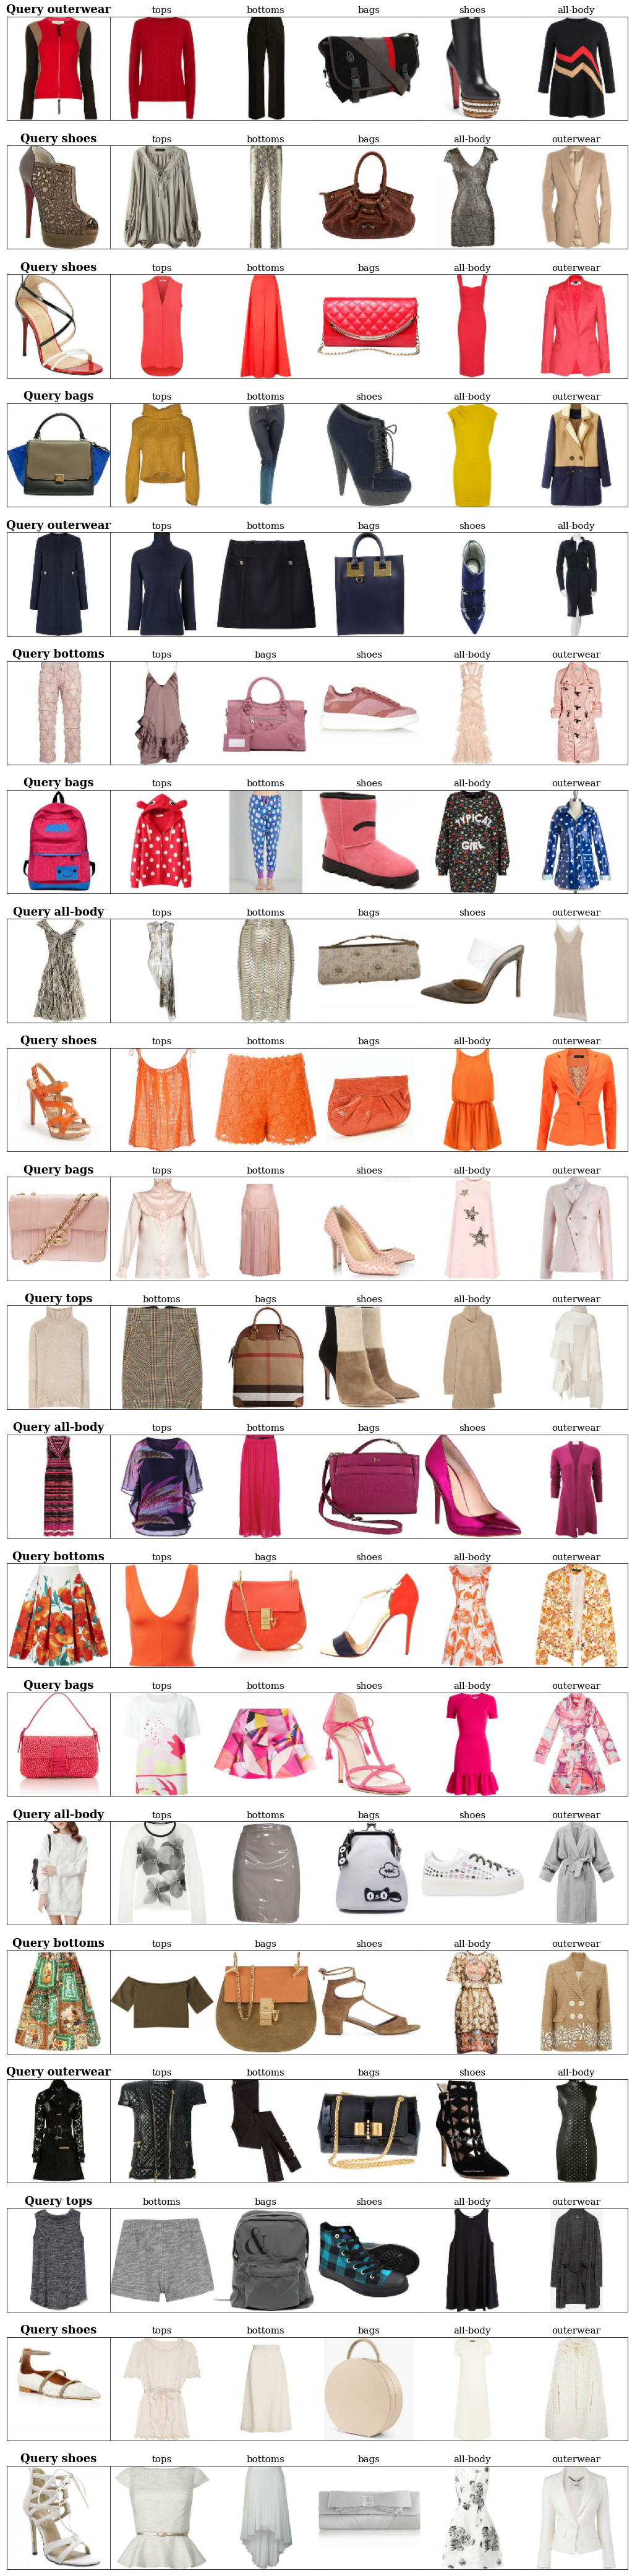

In [12]:
show_query(query_ans_ls)